In [7]:
import pandas as pd
from copy import deepcopy
from collections import Counter
import os

from utils_fetch import start_date, end_date, query_terms_list, year_list, DATA_DIR

In [116]:
def clean_series(series: pd.Series) -> pd.Series:
    # Apply the transformations to each element of the series
    return series.astype(str).str.strip().str.rstrip('.')

# def clean_series(series: pd.Series) -> pd.Series:
#     # Apply the transformations to each element of the series
#     return series

def clean_abstract_column(df):
    # Check if 'abstract' column exists
    if 'abstract' in df.columns:
        # Apply the cleaning process to each entry in the 'abstract' column
        df['abstract'] = clean_series(df['abstract'].str.replace('<i>', '', regex=False)\
                                       .str.replace('</i>', '', regex=False)\
                                       .str.replace('<b>', '', regex=False)\
                                       .str.replace('</b>', '', regex=False)\
                                       .str.replace('\n', ' ', regex=False))
    if 'title' in df.columns:
        # Apply the cleaning process to each entry in the 'abstract' column
        df['title'] = clean_series(df['title'].str.replace('<i>', '', regex=False)\
                                       .str.replace('</i>', '', regex=False)\
                                       .str.replace('<b>', '', regex=False)\
                                       .str.replace('</b>', '', regex=False)\
                                       .str.replace('\n', ' ', regex=False))
        
    else:
        print("The 'abstract' column does not exist in the DataFrame.")
    
    return df

def merge_by_title_and_abstract(df):
    # First, handle cases where titles are the same
    grouped_by_title = df.groupby('title', as_index=False).agg({
        'abstract': lambda x: '\n==========\n'.join([str(item) for item in set(x) if pd.notna(item)]),
        'source': lambda x: ','.join(set(x))
    })
    
    # Next, handle cases where abstracts are the same but titles are different
    grouped_by_abstract = grouped_by_title.groupby('abstract', as_index=False).agg({
        'title': lambda x: '\n==========\n'.join([str(item) for item in set(x) if pd.notna(item)]),
        'source': lambda x: ','.join(set(x))
    })
    
    return grouped_by_abstract[['title', "abstract", 'source']]

# Load your data (assuming it's a CSV file)
df = pd.read_csv(os.path.join(DATA_DIR, '0_all.csv')) [['title', 'abstract', 'source']]
print("Total:", df.shape)
print("By source:", Counter(df.source))
# display(df[df.title.fillna('').str.contains('varchat', case=False)])
df = clean_abstract_column(df)
print(df.shape)
df = merge_by_title_and_abstract(df)
df['title_abstract'] = df['title'] + ' ' + df['abstract']
df

,title,abstract,source
0,Advances in physiological and clinical relevan...,"Precision, or personalized, medicine aims to s...",PubMed
1,The widely used Ucp1-Cre transgene elicits com...,Bacterial artificial chromosome transgenic mod...,PubMed
2,Artificial intelligence in clinical genetics.,Artificial intelligence (AI) has been growing ...,PubMed
3,Embryoscopy and targeted embryo biopsy for the...,"To evaluate the safety, accuracy, and effectiv...",PubMed
4,Association of TCF7L2 genetic variants rs12255...,A significant overlap in the pathophysiologica...,PubMed
...,...,...,...
120,A search-based geographic metadata curation pi...,The National Center for Biotechnology Informat...,PubMed
121,Enhancing luciferase activity and stability th...,The availability of natural protein sequences ...,PubMed
122,Harnessing Generative AI to Decode Enzyme Cata...,"Enzymes, as paramount protein catalysts, occup...",PubMed
123,Generative models for protein sequence modelin...,The widespread adoption of high-throughput omi...,PubMed


In [117]:
print(sum(df.abstract.apply(lambda x: 'tri-coat' in str(x).lower())))

df[df.title.apply(lambda x: 'varchat' in x.lower())]

0


,title,abstract,source
43,VarChat: the generative AI assistant for the i...,"In the modern era of genomic research, the sci...",PubMed


In [10]:
len(df.abstract), len(df.abstract.unique())

(27664, 27664)

## Raw check

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate the number of articles from each source and plot a histogram with seaborn
def plot_article_source_histogram(df, save_path=None, up_size=100):
    # Filter out rows where 'title' or 'abstract' are missing
    df_cleaned = df.dropna(subset=['title', 'abstract'])
    
    # Count the number of articles per source
    article_count_per_source = df_cleaned['source'].value_counts().reset_index()
    article_count_per_source.columns = ['source', 'count']

    # Plot the histogram using seaborn with pastel colors and black border
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='source', y='count', data=article_count_per_source, palette='pastel', edgecolor='black', linewidth=1.5)
    
    # Add values above each bar
    for index, row in article_count_per_source.iterrows():
        ax.text(index, row['count'] + up_size, int(row['count']), color='black', ha="center", fontsize=10)
    
    # Customizing the plot
    plt.title('Number of Articles from Each Source', fontsize=14)
    plt.xlabel('Source', fontsize=12)
    plt.ylabel('Number of Articles', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf')

    # Show the plot
    plt.show()

In [54]:
Counter(df.source)

doubled_sources = {'PubMed,biorxiv,biorxiv':'PubMed,biorxiv',
          'PubMed,PubMed,arXiv':'PubMed,arXiv',
          'PubMed,medrxiv,medrxiv':'PubMed,medrxiv'}
for key, value in doubled_sources.items():
    df.loc[df.source==key,'source']=value

In [55]:
Counter(df.source)

Counter({'PubMed': 9497,
         'biorxiv': 8164,
         'arXiv': 5454,
         'medrxiv': 4338,
         'PubMed,biorxiv': 70,
         'PubMed,arXiv': 60,
         'PubMed,medrxiv': 54,
         'arXiv,medrxiv': 17,
         'arXiv,biorxiv': 7,
         'PubMed,arXiv,biorxiv': 2,
         'medrxiv,biorxiv': 1})

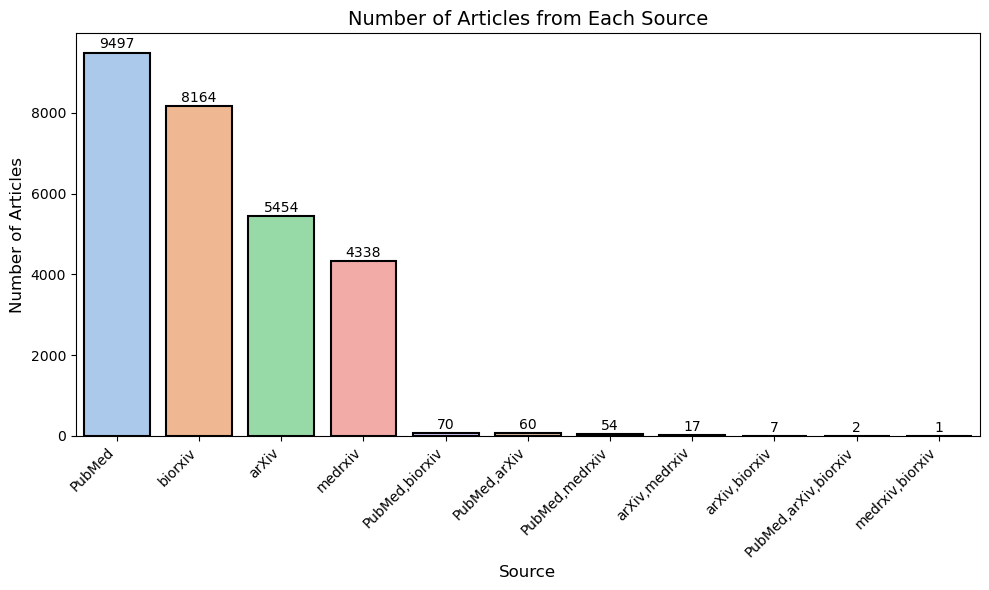

In [58]:
# Plot the histogram for the first time with all articles
initial_histogram = plot_article_source_histogram(df, save_path="imgs/Fig2.pdf")

In [65]:
df.to_csv(os.path.join(DATA_DIR, "cleaned.csv"), index=False)
df_cleaned = df

## Basic text stuff

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [67]:
# Example function for TF-IDF and frequency (count) analysis
def extract_tfidf_and_frequency(df, text_column):
    # TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[text_column])
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

    # Frequency (Count) Vectorizer
    count_vectorizer = CountVectorizer(stop_words='english', max_features=100)
    count_matrix = count_vectorizer.fit_transform(df[text_column])
    count_feature_names = count_vectorizer.get_feature_names_out()
    count_df = pd.DataFrame(count_matrix.toarray(), columns=count_feature_names)

    return tfidf_df, count_df

# Function to handle title, abstract, and both
def analyze_title_abstract(df):
    # TF-IDF and frequency for title
    title_tfidf, title_count = extract_tfidf_and_frequency(df, 'title')

    # TF-IDF and frequency for abstract
    abstract_tfidf, abstract_count = extract_tfidf_and_frequency(df, 'abstract')

    # TF-IDF and frequency for title + abstract
    title_abstract_tfidf, title_abstract_count = extract_tfidf_and_frequency(df, 'title_abstract')

    return title_tfidf, title_count, abstract_tfidf, abstract_count, title_abstract_tfidf, title_abstract_count




def plot_top_terms(df, title, top_n=20):
    """
    Plots the top N terms from a DataFrame where each column represents a term
    and each row represents a document.
    """
    # Get average scores per term
    term_scores = df.mean().sort_values(ascending=False).head(top_n)
    
    # Create a DataFrame for plotting
    term_df = pd.DataFrame({'term': term_scores.index, 'score': term_scores.values})
    
    # Plotting using seaborn and pastel colors
    sns.set(style="whitegrid", palette="pastel")
    plt.figure(figsize=(10, 20))
    sns.barplot(x="score", y="term", data=term_df, palette="pastel")
    plt.title(f"Top {top_n} Terms for {title}")
    plt.xlabel("Score")
    plt.ylabel("Term")
    plt.show()

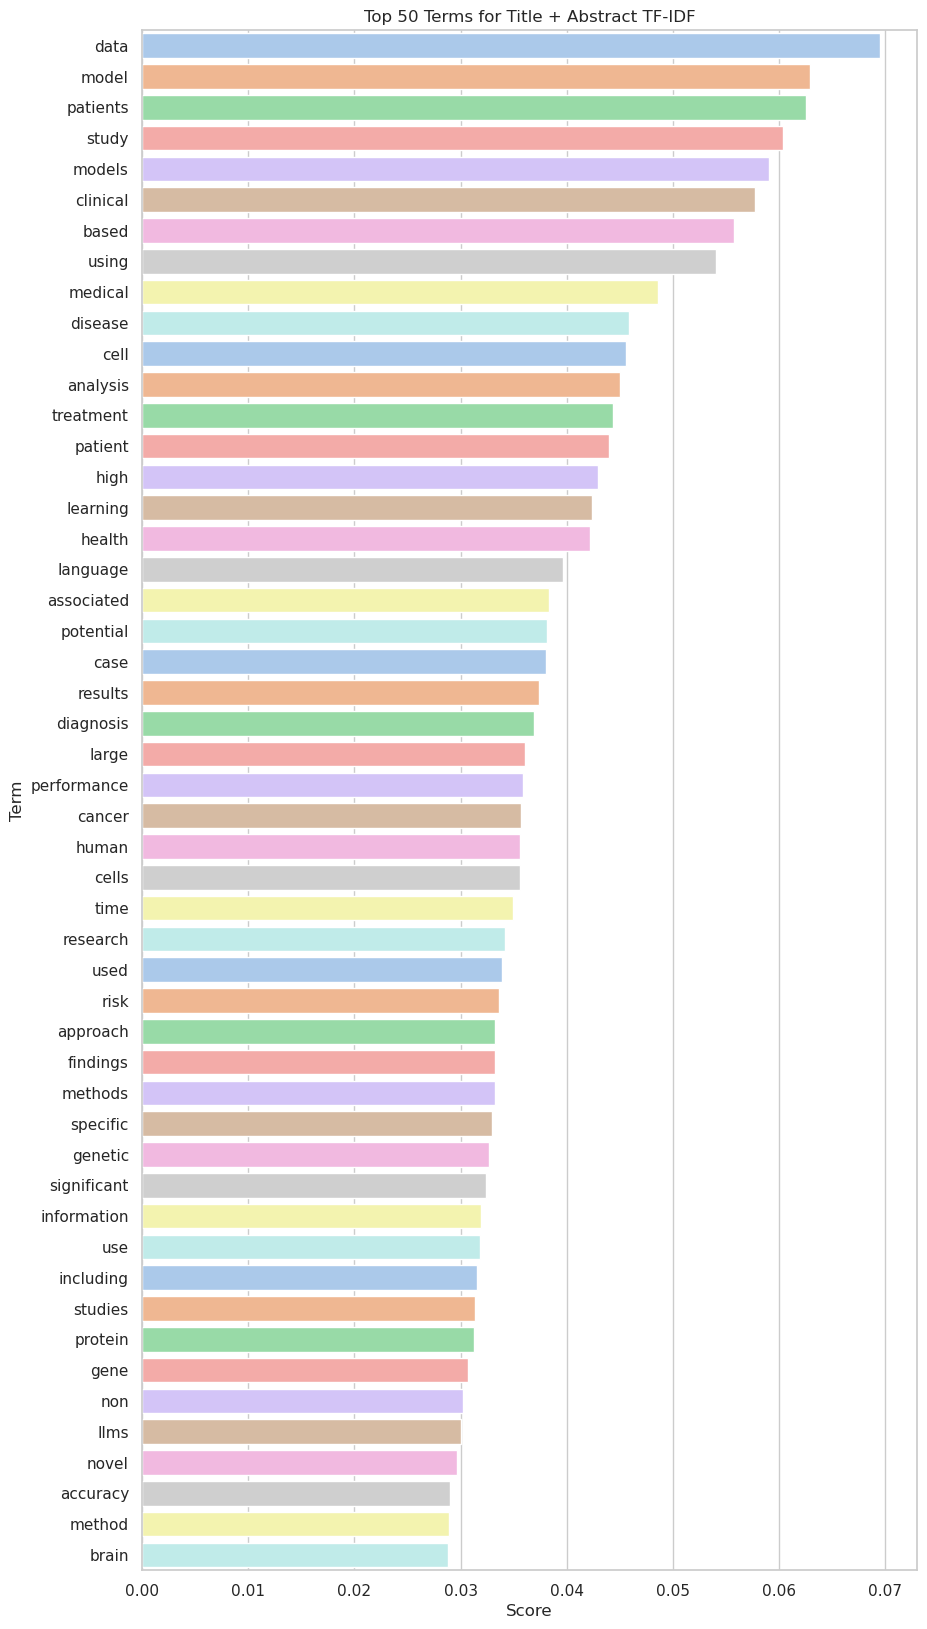

In [68]:
title_tfidf, title_count, abstract_tfidf, abstract_count, title_abstract_tfidf, title_abstract_count = analyze_title_abstract(df_cleaned)


# Example usage
# # Plot for title TF-IDF
# plot_top_terms(title_tfidf, "Title TF-IDF")
# # # Plot for title count
# # plot_top_terms(title_count, "Title Term Frequency")

# # Plot for abstract TF-IDF
# plot_top_terms(abstract_tfidf, "Abstract TF-IDF")
# # # Plot for abstract count
# # plot_top_terms(abstract_count, "Abstract Term Frequency")

# Plot for combined title and abstract TF-IDF
plot_top_terms(title_abstract_tfidf, "Title + Abstract TF-IDF", 50)
# # Plot for combined title and abstract count
# plot_top_terms(title_abstract_count, "Title + Abstract Term Frequency")

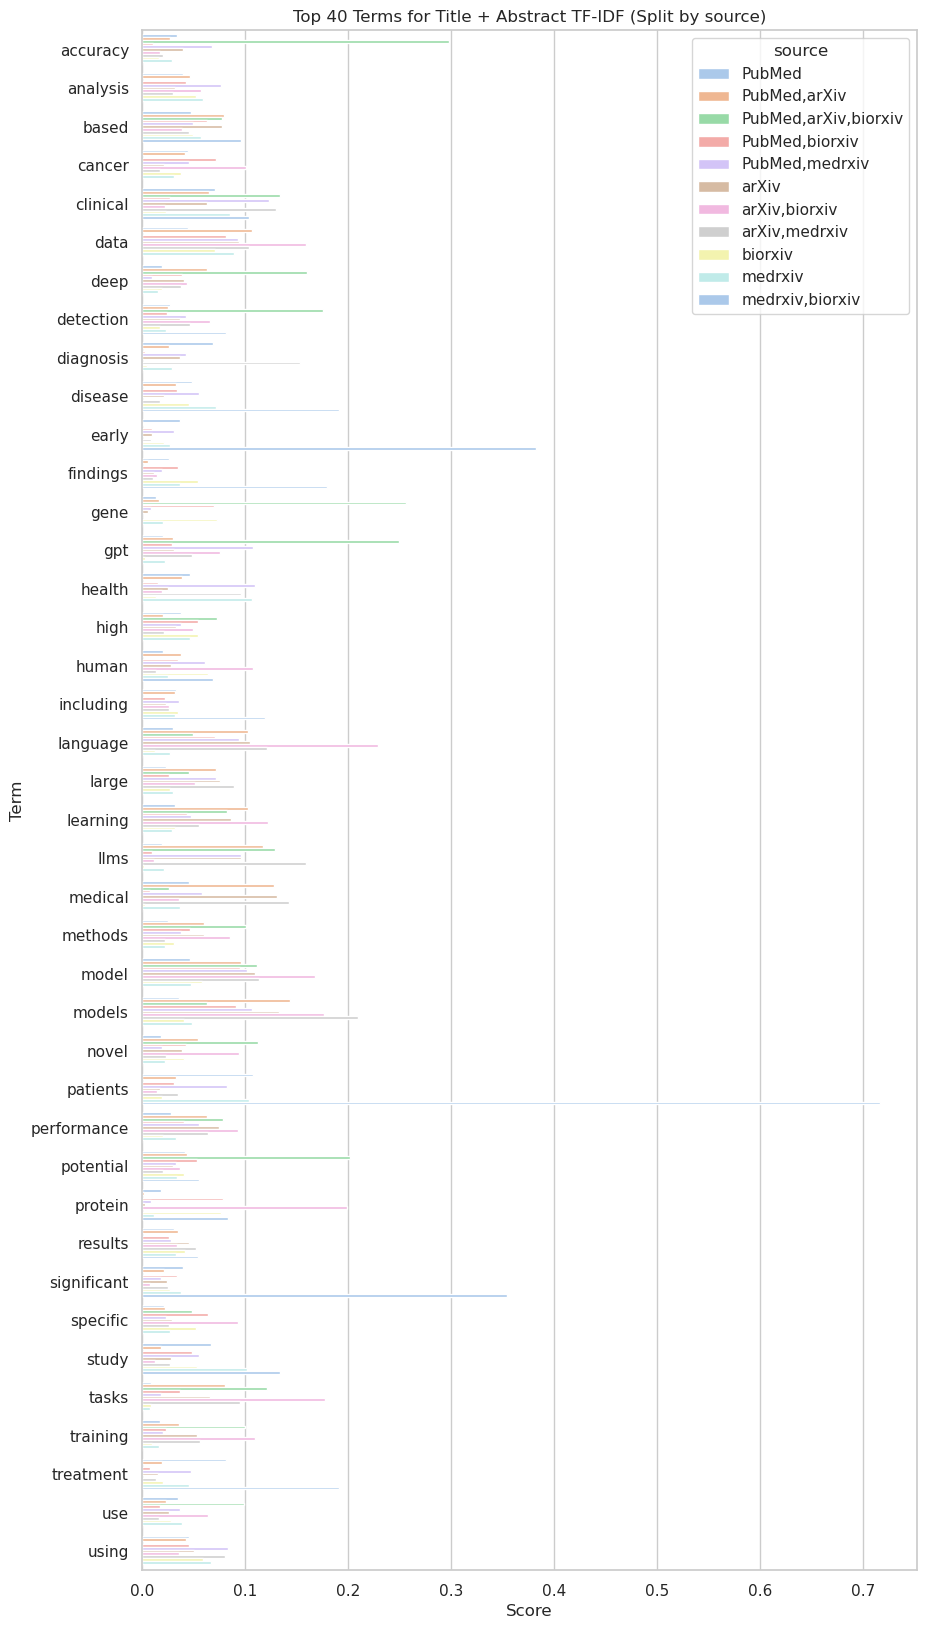

In [69]:

def plot_top_terms_with_source(df, source_col, title, top_n=40):
    """
    Plots the top N terms from a DataFrame where each column represents a term
    and each row represents a document, splitting bars based on the source column.
    """
    # Melt the dataframe to long format for seaborn, keeping the source column
    df_long = df.melt(id_vars=[source_col], var_name="term", value_name="score")
    
    # Group by source and term, and compute mean score per group
    df_grouped = df_long.groupby([source_col, "term"]).mean().reset_index()
    
    # Select the top N terms by average score across all sources
    top_terms = df_grouped.groupby("term")["score"].mean().sort_values(ascending=False).head(top_n).index
    df_top = df_grouped[df_grouped["term"].isin(top_terms)]
    
    # Plotting
    sns.set(style="whitegrid", palette="pastel")
    plt.figure(figsize=(10, 20))
    
    # Create a grouped bar plot where bars are split by source
    sns.barplot(x="score", y="term", hue=source_col, data=df_top, palette="pastel")
    
    # Customize the plot
    plt.title(f"Top {top_n} Terms for {title} (Split by {source_col})")
    plt.xlabel("Score")
    plt.ylabel("Term")
    plt.legend(title=source_col)
    plt.show()

# Example usage:
# Assuming 'source' column is available in your dataframe (e.g., journal name, study type)
# Plot for title+abstract TF-IDF, splitting bars by source
plot_top_terms_with_source(title_abstract_tfidf.assign(source=df['source']), 'source', "Title + Abstract TF-IDF")

## Same for bigrams and trigrams

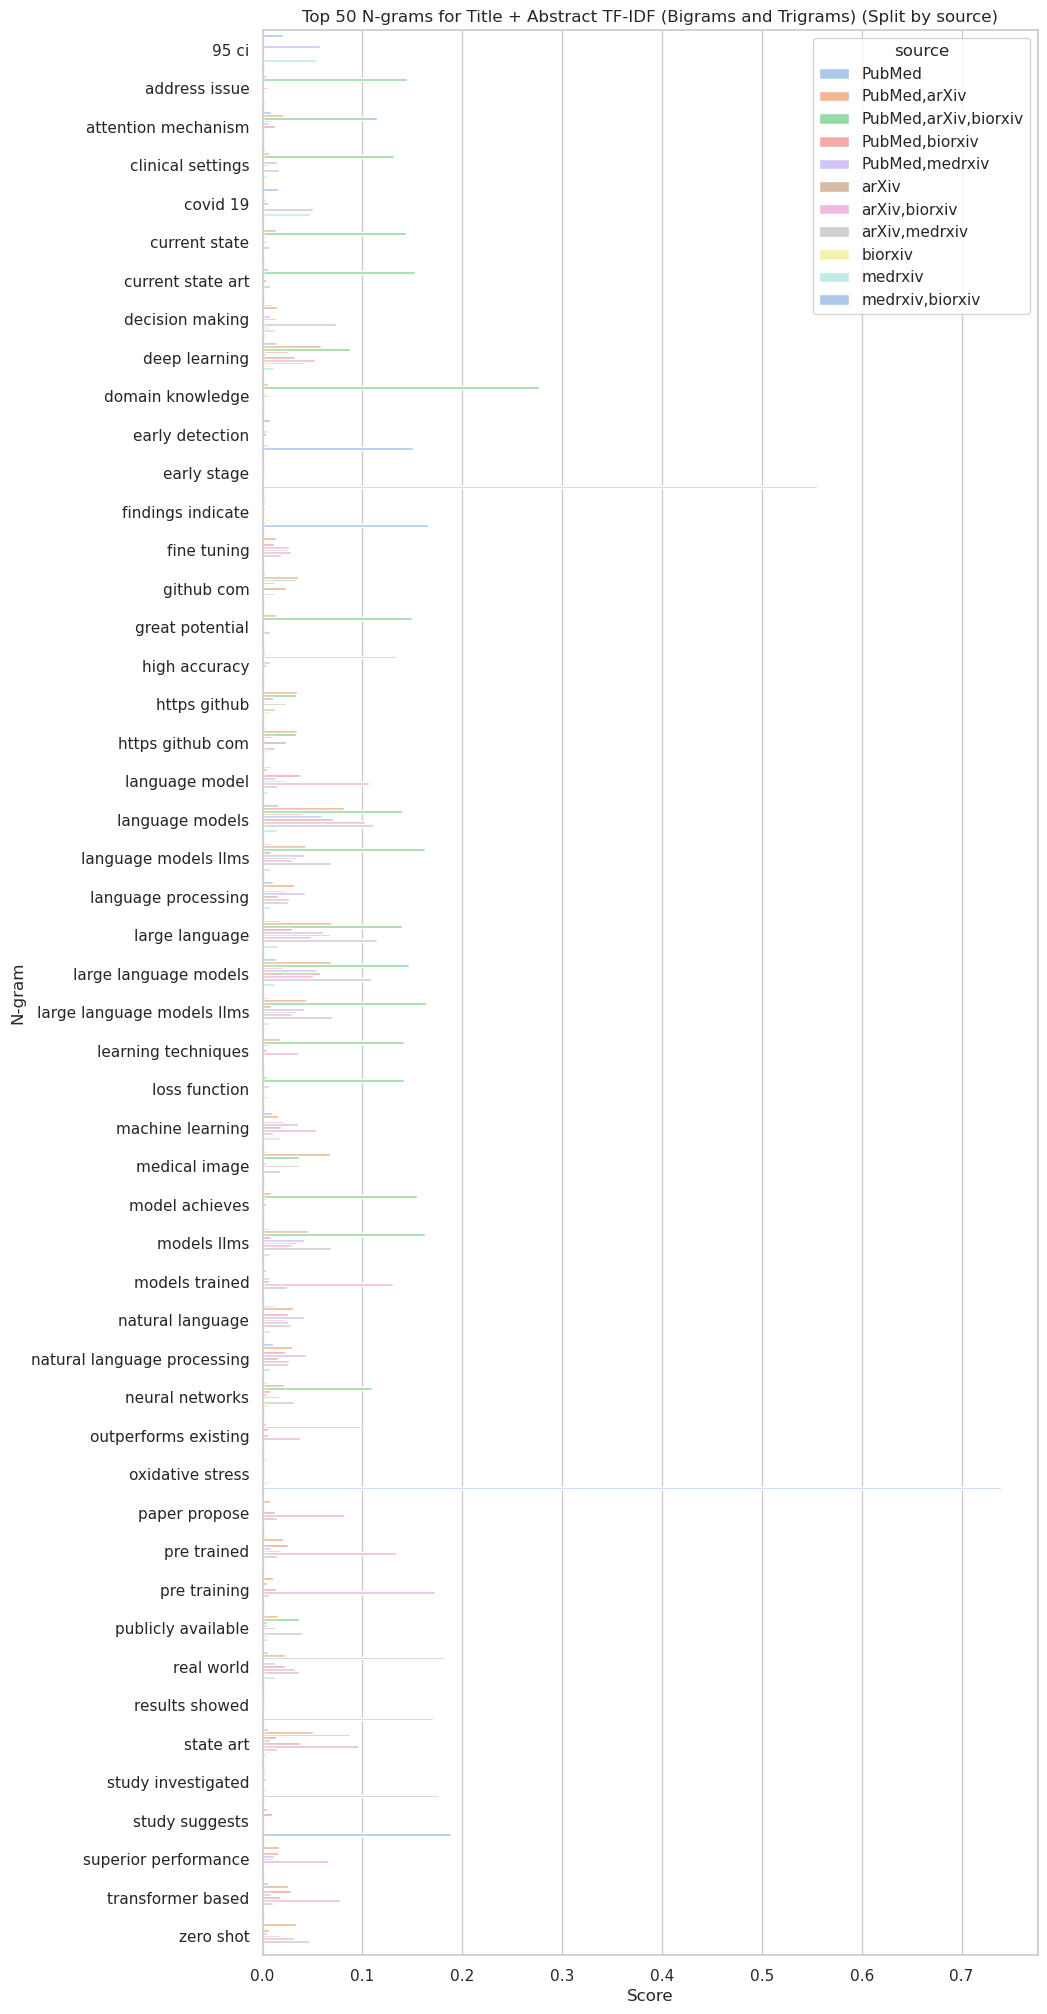

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

# Modify the TF-IDF extraction function to handle n-grams
def extract_tfidf_and_frequency_ngrams(df, text_column, ngram_range=(2, 3)):
    # TF-IDF Vectorizer for bigrams and trigrams
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=ngram_range, max_features=1000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[text_column])
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

    # Frequency (Count) Vectorizer for bigrams and trigrams
    count_vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram_range, max_features=1000)
    count_matrix = count_vectorizer.fit_transform(df[text_column])
    count_feature_names = count_vectorizer.get_feature_names_out()
    count_df = pd.DataFrame(count_matrix.toarray(), columns=count_feature_names)

    return tfidf_df, count_df

# Function to plot bigrams and trigrams with source column
def plot_top_ngrams_with_source(df, source_col, title, top_n=50):
    """
    Plots the top N n-grams from a DataFrame where each column represents a term
    (bigram or trigram) and each row represents a document, splitting bars based on the source column.
    """
    # Melt the dataframe to long format for seaborn, keeping the source column
    df_long = df.melt(id_vars=[source_col], var_name="term", value_name="score")
    
    # Group by source and term, and compute mean score per group
    df_grouped = df_long.groupby([source_col, "term"]).mean().reset_index()
    
    # Select the top N terms by average score across all sources
    top_terms = df_grouped.groupby("term")["score"].mean().sort_values(ascending=False).head(top_n).index
    df_top = df_grouped[df_grouped["term"].isin(top_terms)]
    
    # Plotting
    sns.set(style="whitegrid", palette="pastel")
    plt.figure(figsize=(10, 25))
    
    # Create a grouped bar plot where bars are split by source
    sns.barplot(x="score", y="term", hue=source_col, data=df_top, palette="pastel")
    
    # Customize the plot
    plt.title(f"Top {top_n} N-grams for {title} (Split by {source_col})")
    plt.xlabel("Score")
    plt.ylabel("N-gram")
    plt.legend(title=source_col)
    plt.show()

# Example usage:
# Extract bigrams and trigrams for title + abstract column
title_abstract_tfidf_ngrams, title_abstract_count_ngrams = extract_tfidf_and_frequency_ngrams(df, 'title_abstract', ngram_range=(2, 4))

# Assuming 'source' column is available in your dataframe (e.g., journal name, study type)
# Plot for title+abstract bigrams/trigrams TF-IDF, splitting bars by source
plot_top_ngrams_with_source(title_abstract_tfidf_ngrams.assign(source=df['source']), 'source', "Title + Abstract TF-IDF (Bigrams and Trigrams)")

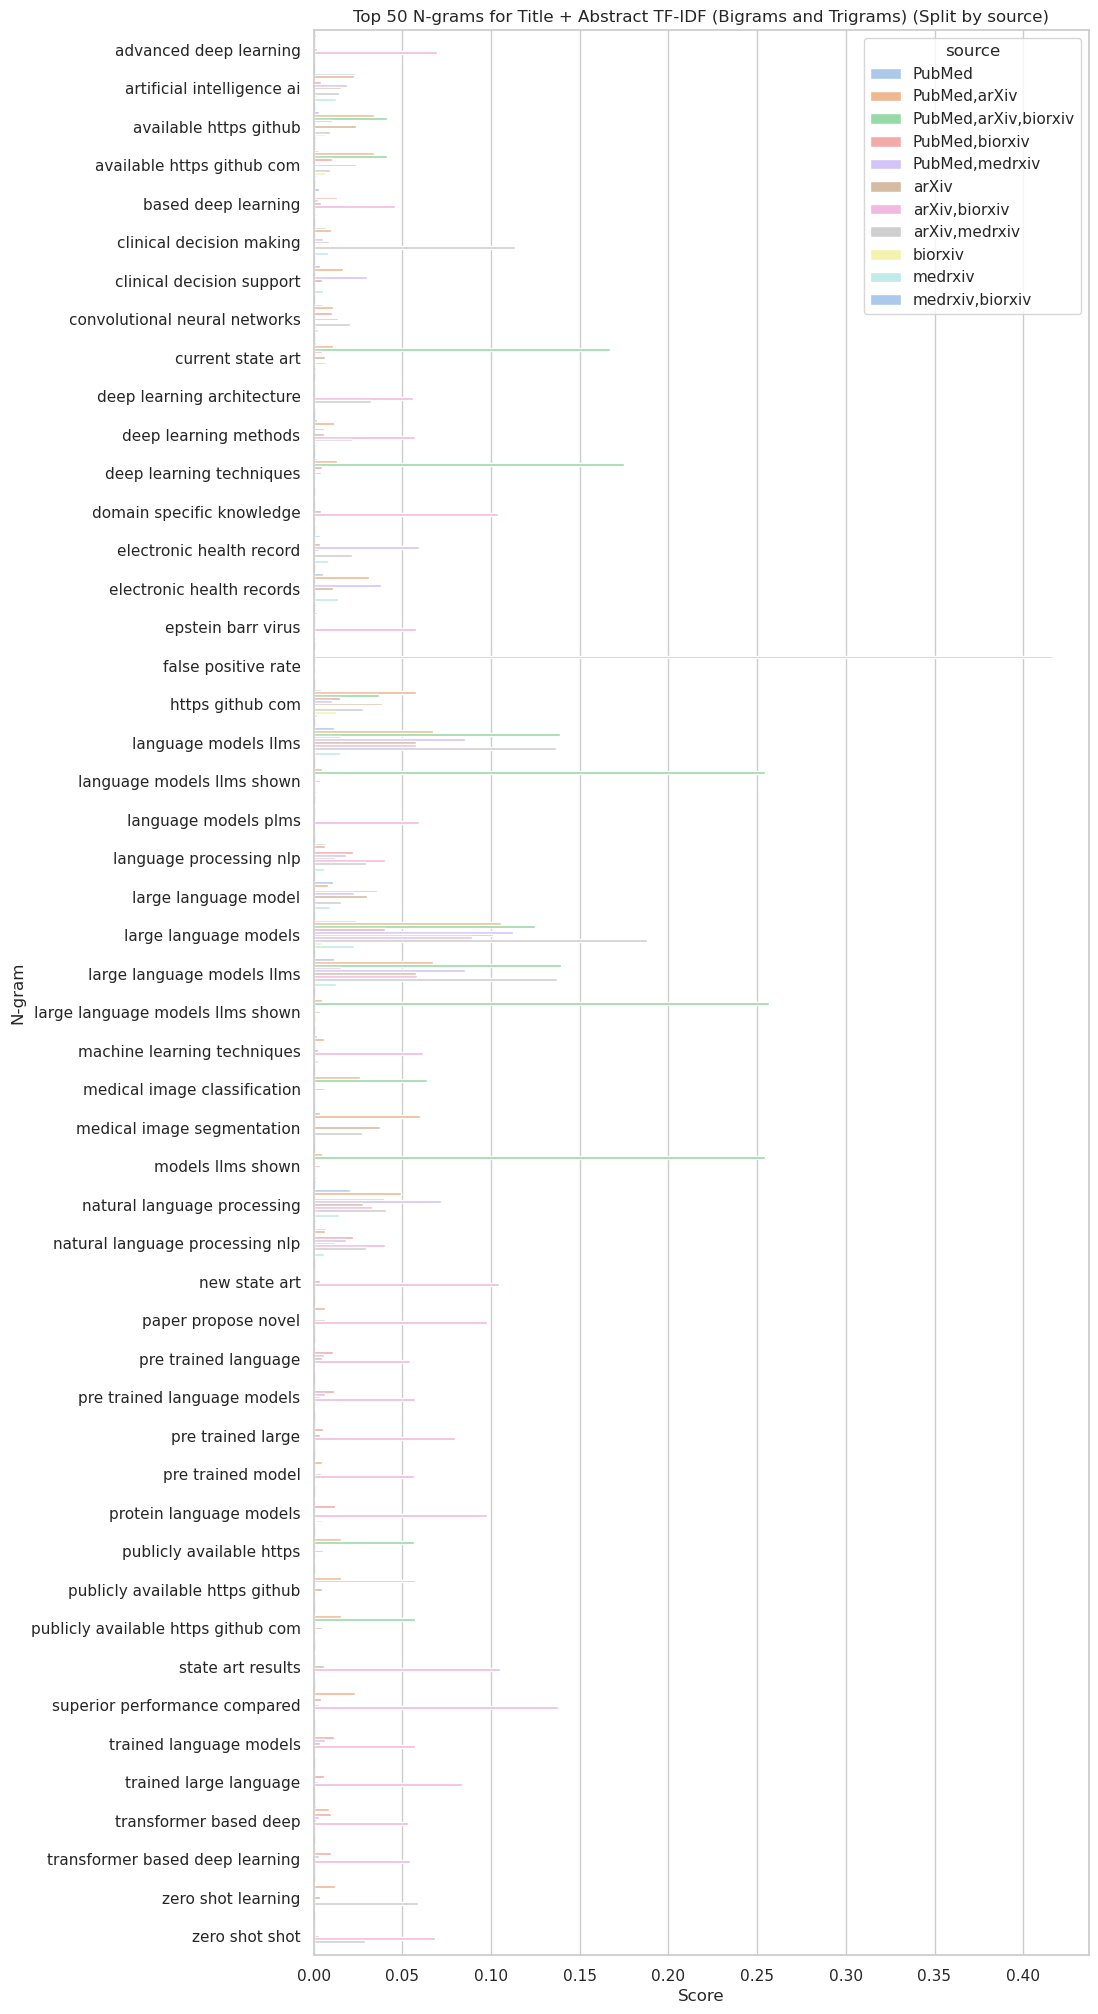

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

# Modify the TF-IDF extraction function to handle n-grams
def extract_tfidf_and_frequency_ngrams(df, text_column, ngram_range=(2, 3)):
    # TF-IDF Vectorizer for bigrams and trigrams
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=ngram_range, max_features=1000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[text_column])
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

    # Frequency (Count) Vectorizer for bigrams and trigrams
    count_vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram_range, max_features=1000)
    count_matrix = count_vectorizer.fit_transform(df[text_column])
    count_feature_names = count_vectorizer.get_feature_names_out()
    count_df = pd.DataFrame(count_matrix.toarray(), columns=count_feature_names)

    return tfidf_df, count_df

# Function to plot bigrams and trigrams with source column
def plot_top_ngrams_with_source(df, source_col, title, top_n=50):
    """
    Plots the top N n-grams from a DataFrame where each column represents a term
    (bigram or trigram) and each row represents a document, splitting bars based on the source column.
    """
    # Melt the dataframe to long format for seaborn, keeping the source column
    df_long = df.melt(id_vars=[source_col], var_name="term", value_name="score")
    
    # Group by source and term, and compute mean score per group
    df_grouped = df_long.groupby([source_col, "term"]).mean().reset_index()
    
    # Select the top N terms by average score across all sources
    top_terms = df_grouped.groupby("term")["score"].mean().sort_values(ascending=False).head(top_n).index
    df_top = df_grouped[df_grouped["term"].isin(top_terms)]
    
    # Plotting
    sns.set(style="whitegrid", palette="pastel")
    plt.figure(figsize=(10, 25))
    
    # Create a grouped bar plot where bars are split by source
    sns.barplot(x="score", y="term", hue=source_col, data=df_top, palette="pastel")
    
    # Customize the plot
    plt.title(f"Top {top_n} N-grams for {title} (Split by {source_col})")
    plt.xlabel("Score")
    plt.ylabel("N-gram")
    plt.legend(title=source_col)
    plt.show()

# Example usage:
# Extract bigrams and trigrams for title + abstract column
title_abstract_tfidf_ngrams, title_abstract_count_ngrams = extract_tfidf_and_frequency_ngrams(df, 'title_abstract', ngram_range=(3, 5))

# Assuming 'source' column is available in your dataframe (e.g., journal name, study type)
# Plot for title+abstract bigrams/trigrams TF-IDF, splitting bars by source
plot_top_ngrams_with_source(title_abstract_tfidf_ngrams.assign(source=df['source']), 'source', "Title + Abstract TF-IDF (Bigrams and Trigrams)")

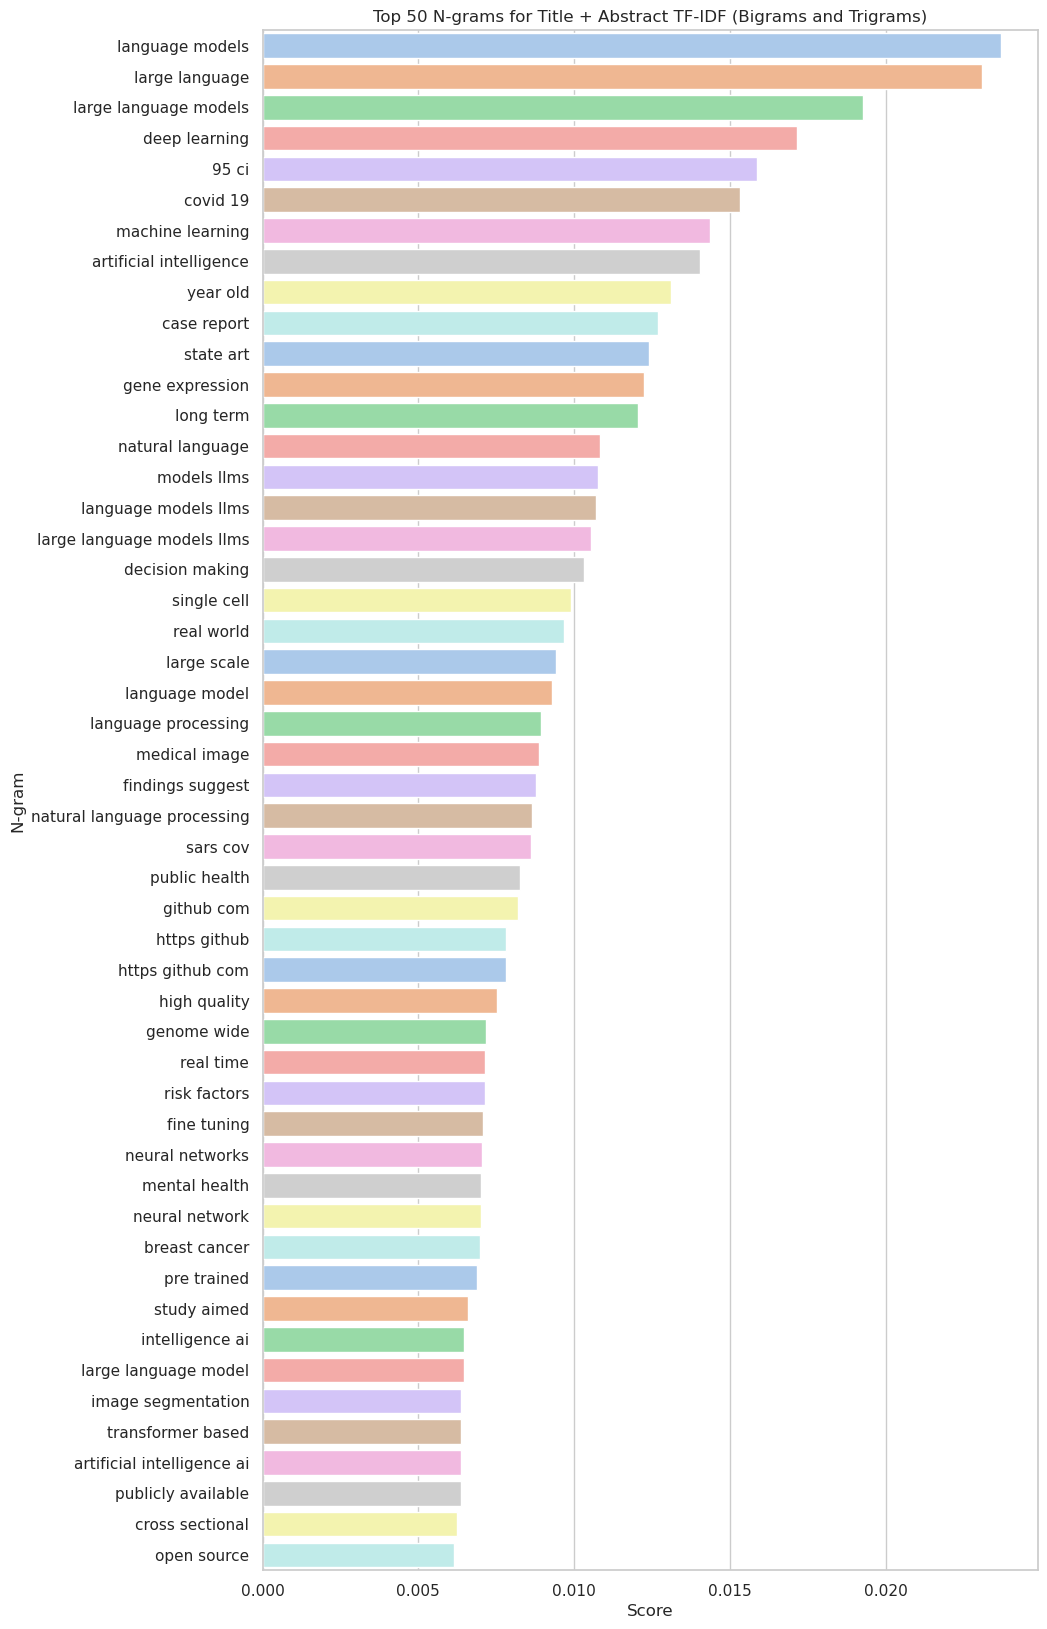

In [72]:
# Function to plot bigrams and trigrams without source splitting
def plot_top_ngrams(df, title, top_n=50):
    """
    Plots the top N n-grams from a DataFrame where each column represents a term
    (bigram or trigram) and each row represents a document.
    """
    # Get average scores per term
    term_scores = df.mean().sort_values(ascending=False).head(top_n)
    
    # Create a DataFrame for plotting
    term_df = pd.DataFrame({'term': term_scores.index, 'score': term_scores.values})
    
    # Plotting
    sns.set(style="whitegrid", palette="pastel")
    plt.figure(figsize=(10, 20))
    
    # Create a bar plot for top terms
    sns.barplot(x="score", y="term", data=term_df, palette="pastel")
    
    # Customize the plot
    plt.title(f"Top {top_n} N-grams for {title}")
    plt.xlabel("Score")
    plt.ylabel("N-gram")
    plt.show()

# Example usage:
# Extract bigrams and trigrams for title + abstract column
title_abstract_tfidf_ngrams, title_abstract_count_ngrams = extract_tfidf_and_frequency_ngrams(df, 'title_abstract', ngram_range=(2, 4))

# Plot for title+abstract bigrams/trigrams TF-IDF
plot_top_ngrams(title_abstract_tfidf_ngrams, "Title + Abstract TF-IDF (Bigrams and Trigrams)")

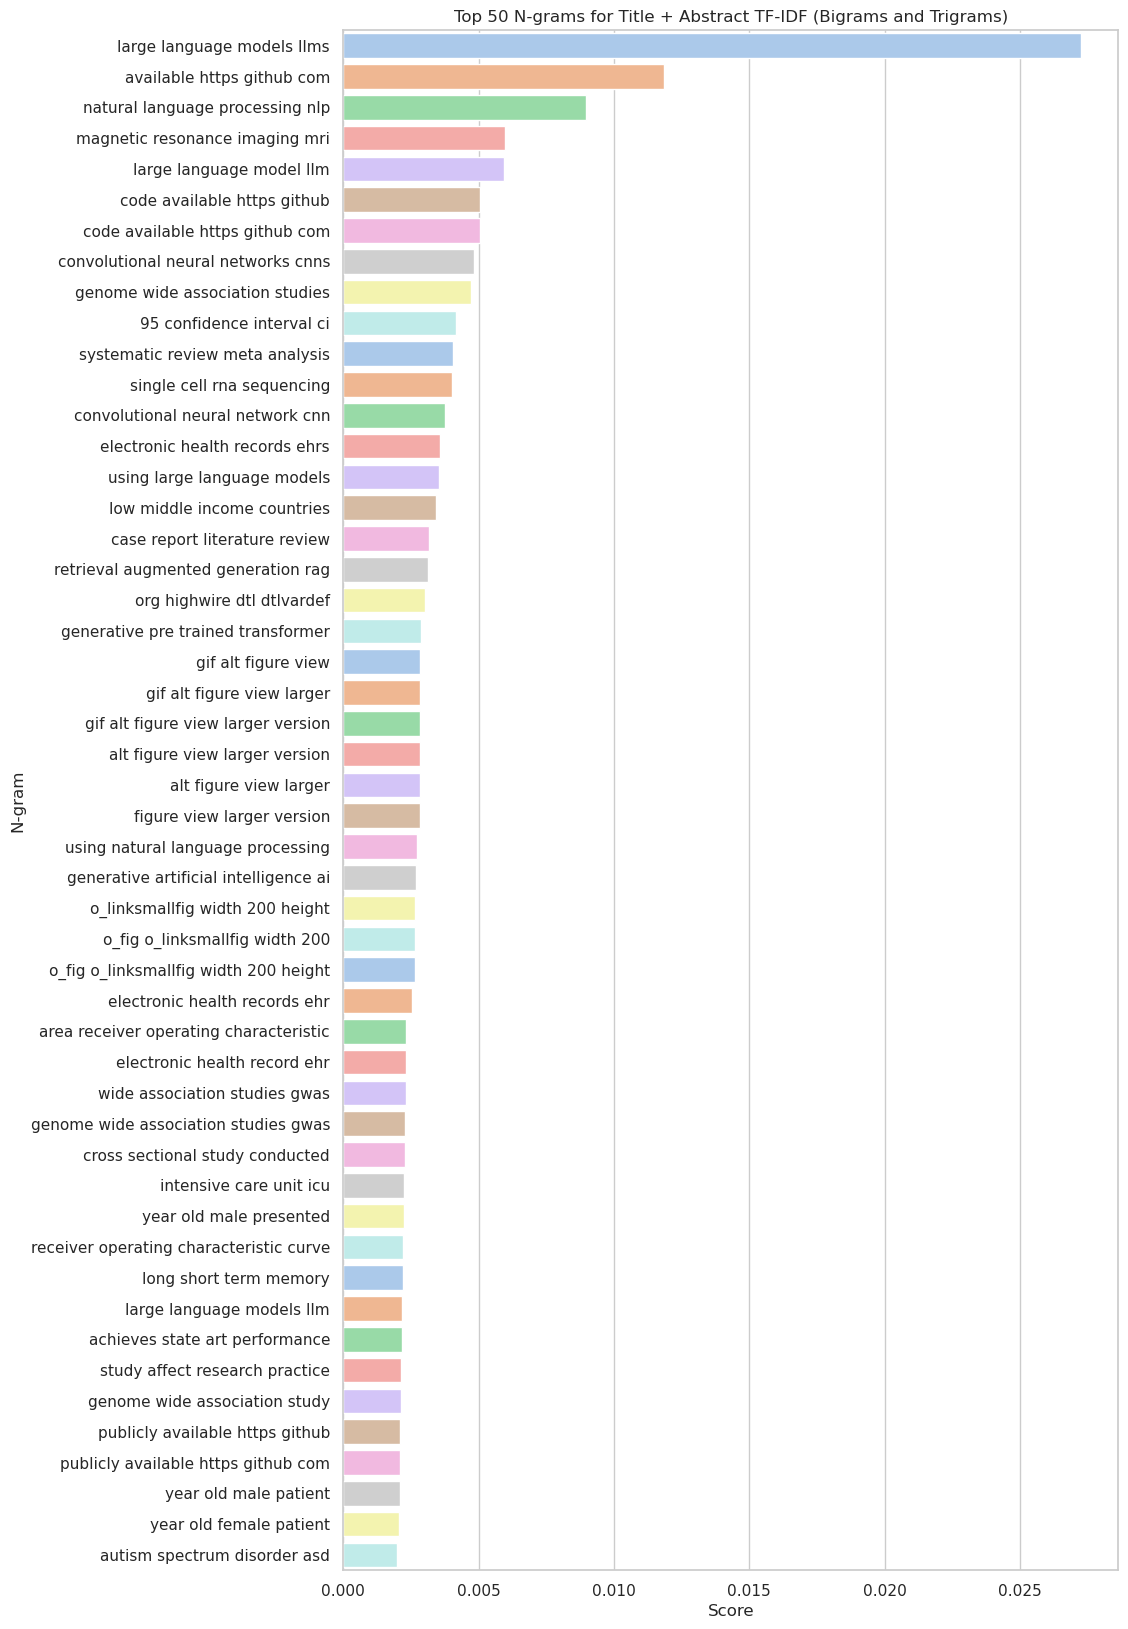

In [73]:
# Example usage:
# Extract bigrams and trigrams for title + abstract column
title_abstract_tfidf_ngrams, title_abstract_count_ngrams = extract_tfidf_and_frequency_ngrams(df, 'title_abstract', ngram_range=(4, 6))

# Plot for title+abstract bigrams/trigrams TF-IDF
plot_top_ngrams(title_abstract_tfidf_ngrams, "Title + Abstract TF-IDF (Bigrams and Trigrams)")

## Exclude some words

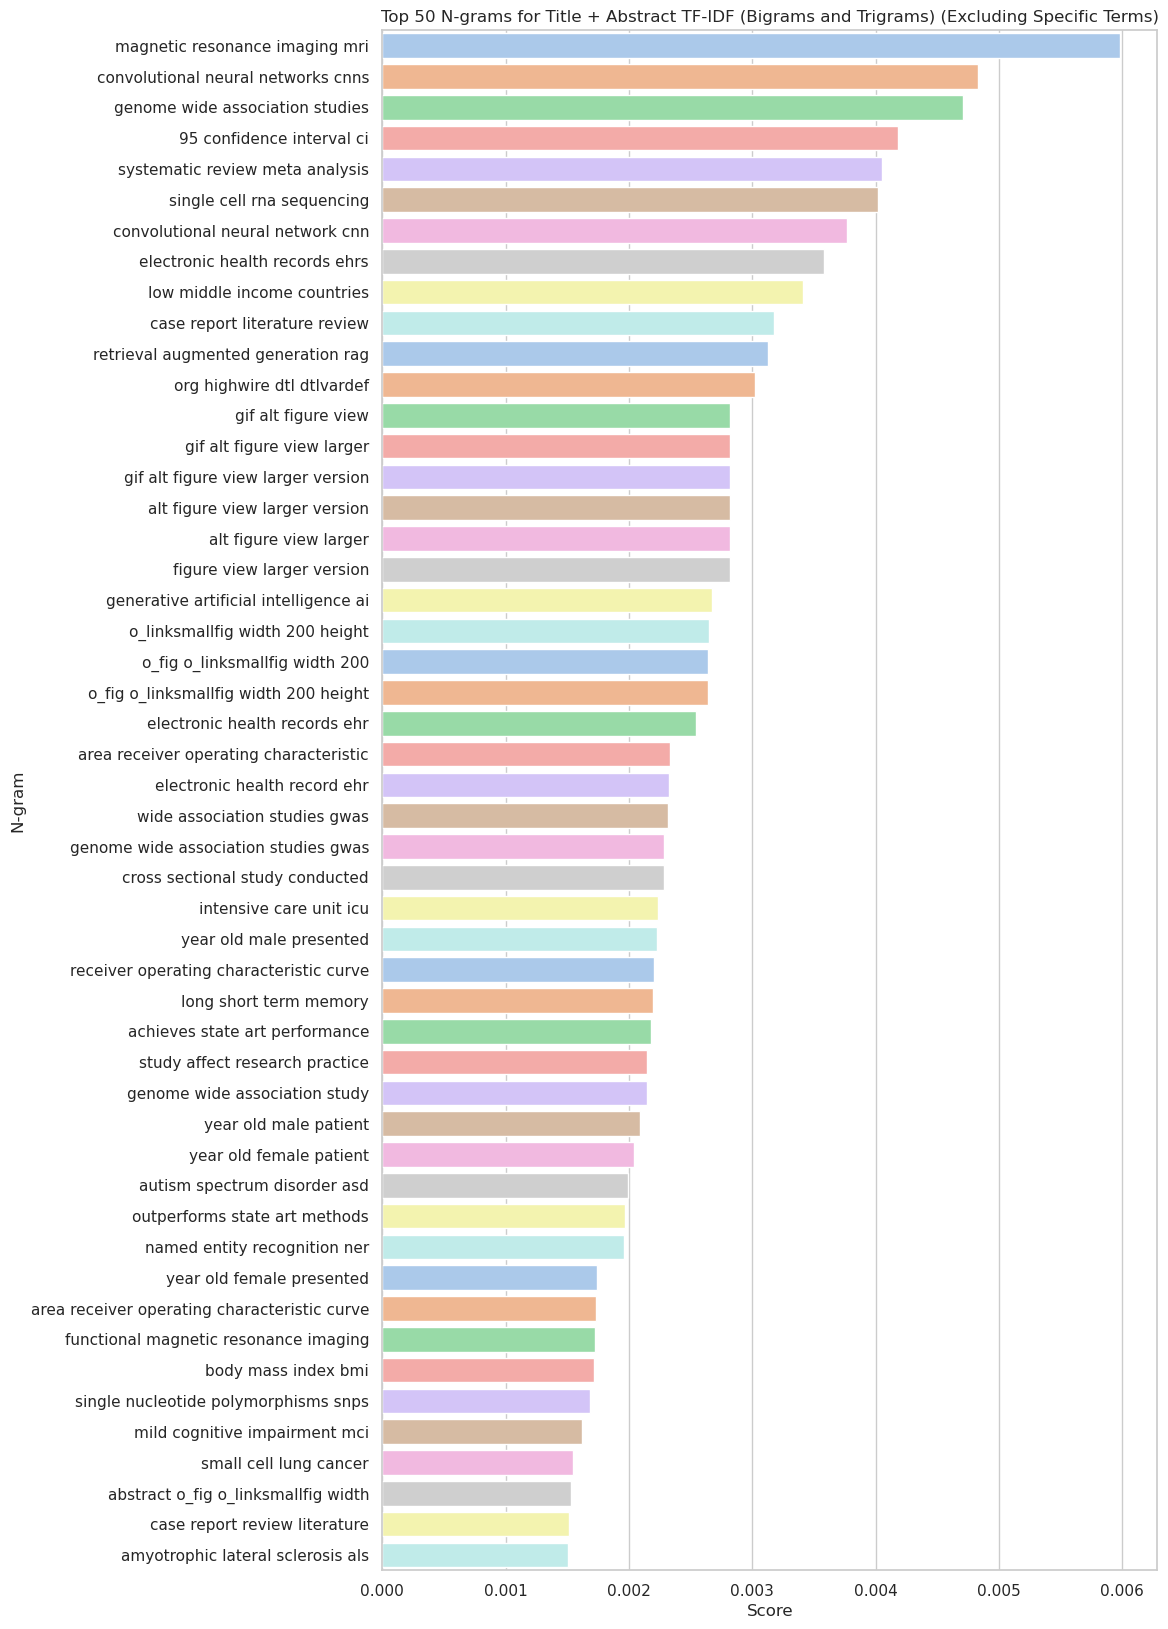

In [74]:
# Function to plot bigrams and trigrams without source splitting, excluding specific n-grams
def plot_top_ngrams_with_exclusion(df, title, top_n=50, exclude_terms=None):
    """
    Plots the top N n-grams from a DataFrame where each column represents a term
    (bigram or trigram) and each row represents a document. Excludes specific terms.
    """
    if exclude_terms is None:
        exclude_terms = ['language', 'model', 'models', 'learning', 'llm', 'llms']

    # Get average scores per term
    term_scores = df.mean().sort_values(ascending=False)
    
    # Filter out n-grams that contain any of the excluded terms
    filtered_term_scores = term_scores[~term_scores.index.str.contains('|'.join(exclude_terms))]
    
    # Select the top N terms after filtering
    top_terms = filtered_term_scores.head(top_n)
    
    # Create a DataFrame for plotting
    term_df = pd.DataFrame({'term': top_terms.index, 'score': top_terms.values})
    
    # Plotting
    sns.set(style="whitegrid", palette="pastel")
    plt.figure(figsize=(10, 20))
    
    # Create a bar plot for top terms
    sns.barplot(x="score", y="term", data=term_df, palette="pastel")
    
    # Customize the plot
    plt.title(f"Top {top_n} N-grams for {title} (Excluding Specific Terms)")
    plt.xlabel("Score")
    plt.ylabel("N-gram")
    plt.show()

# Example usage:
# Extract bigrams and trigrams for title + abstract column
title_abstract_tfidf_ngrams, title_abstract_count_ngrams = extract_tfidf_and_frequency_ngrams(df, 'title_abstract', ngram_range=(4,6))

# Plot for title+abstract bigrams/trigrams TF-IDF, excluding specific terms
plot_top_ngrams_with_exclusion(title_abstract_tfidf_ngrams, "Title + Abstract TF-IDF (Bigrams and Trigrams)", exclude_terms=['language', 'model', 'models', 'learning', 'llm', 'llms', 'github', 'transformer'])


## Save clinical

In [7]:
# df_cleaned_clinic = df_cleaned_clinic.iloc[511:]

(27664, 5)
(17511, 5)
(11316, 5)
(759, 5)


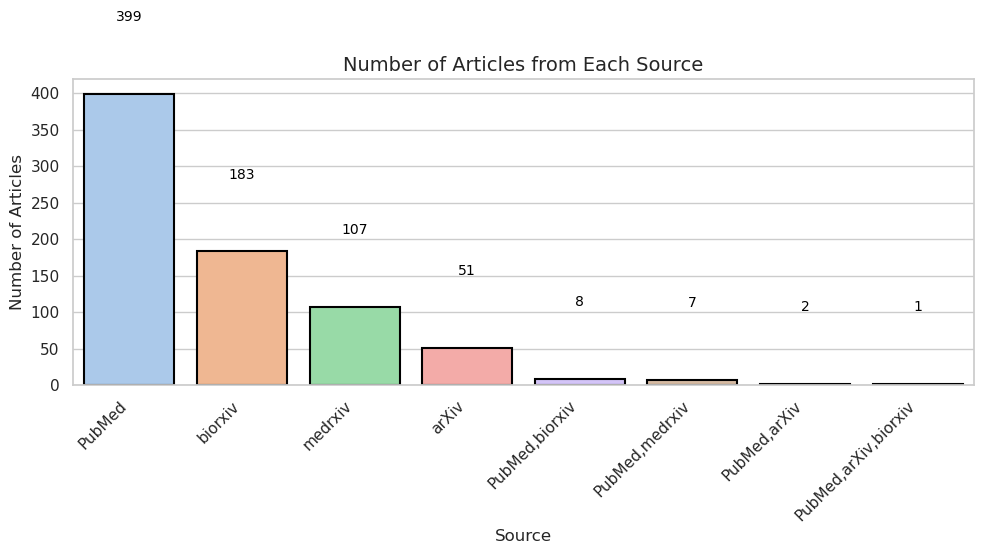

In [87]:
def delete_list(x, list_strings):
    x = x.lower()
    for string in list_strings:
        x = x.replace(string, "")
    return x

def filter_df(df, phrases_to_include, column='title_abstract'):
    filter_condition = df[column].str.contains('|'.join(phrases_to_include), case=False, na=False)
    return df[filter_condition]

phrases_to_include_list = [
    [
        "LLM", 
     "large language model", 
     "NLP", 
     "natural language processing",
     "GPT", 
     "chatGPT", 
     "transformer", 
     "BERT", 
     "Bidirectional Encoder Representation", 
     "RAG", 
     "augmented generation", 
     "generative AI", 
     "AI assistant", 
     "prompt", 
     "chatbot", 
     "prompt engineering", 
     "attention mechanism", 
     "chain-of-thought", 
     "chain of thought", 
     "agent"
    ],
    ['electronic health record', 
     'ehr', 
     'clinical', 
     'case report',
     'cds', 
     "intensive care unit",
     'medical', 
     'syndrome', 
     'phenotype', 
     "complex trait"],
    [
        "inherit", 
     "heredit", 
     "heritability", 
     "gwas", 
     "genome-wide", 
     "genome wide", 
     "association stud", 
     "snp",
     "single nucleotide",
     "genetic", 
     "variant interpretation", 
     "genomic varia", 
     "human gen",
     "NGS",
     "generation sequencing"
    ]
]

words_to_remove = ["ungs", "angs", "ongs", "ings", 'eragrostis', 'smallmouth', 'fragile', 'angptl', 'intragenic', 'fragment', 'hallmark', 'uvrag', 'leverag', 'storag', 'averag', 'coverag', 'encourag', 'forage', "liraglutid"]

df_cleaned_clinic = deepcopy(df)

df_cleaned_clinic['title_abstract_removed'] = df_cleaned_clinic['title_abstract'].apply(lambda x: delete_list(x, words_to_remove))


print(df_cleaned_clinic.shape)
for phrases_to_include in phrases_to_include_list:
    df_cleaned_clinic = filter_df(df_cleaned_clinic, phrases_to_include, 'title_abstract_removed')
    df_cleaned_clinic = filter_df(df_cleaned_clinic, phrases_to_include, 'title_abstract')[['title', 'abstract', 'source', 'title_abstract', 'title_abstract_removed']]
    print(df_cleaned_clinic.shape)
    
df_cleaned_clinic = df_cleaned_clinic[~df_cleaned_clinic.abstract.apply(lambda x: str(x)=="nan")]
df_cleaned_clinic.shape
df_cleaned_clinic[['title', 'abstract', 'source',]].to_csv(os.path.join(DATA_DIR, 'clinic_genetic.csv'), index=False)
plot_article_source_histogram(df_cleaned_clinic, up_size=15)

In [76]:
a, b, c = phrases_to_include_list


print(", ".join(a))
print(", ".join(b))
print(", ".join(c))

NameError: name 'phrases_to_include_list' is not defined